In [1]:
# ! pip install MTCNN

#### Align, Crop, Resize, Save Image Using mtcnn

##### Import Libraries

In [2]:
import tensorflow
from mtcnn import MTCNN
import cv2
import os
import glob
import numpy as np
from tqdm import tqdm
import shutil
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

##### Align Image Function

In [3]:
def align(img):
    # This function takes in an image, detects the bounding boxes for the face or faces
    # in the image and then selects the face with the largest number of pixels.
    # for the largest face the eye centers are detected and the angle of the eyes with respect to
    # the horizontal axis is determined. It then provides this angle to the rotate_bound function
    # the rotate_bound function the rotates the image so the eyes are parallel to the horizontal axis
        
    data=detector.detect_faces(img)
    # In case the image has more than 1 face, find the biggest face
    biggest=0
    if data !=[]:
        for faces in data:
            box=faces['box']            
            # calculate the area in the image
            area = box[3]  * box[2]
            if area>biggest:
                biggest=area
                bbox=box                
                keypoints=faces['keypoints']
                left_eye=keypoints['left_eye']
                right_eye=keypoints['right_eye']                 
        lx,ly=left_eye        
        rx,ry=right_eye
        dx=rx-lx
        dy=ry-ly
        tan=dy/dx
        theta=np.arctan(tan)
        theta=np.degrees(theta)    
        img=rotate_bound(img, theta)        
        return (True,img)
    else:
        return (False, None)
 

##### Crop Image Function

In [4]:
def crop_image(img): 
    data=detector.detect_faces(img)
    #y=box[1] h=box[3] x=box[0] w=box[2]   
    biggest=0
    if data !=[]:
        for faces in data:
            box=faces['box']            
            # calculate the area in the image
            area = box[3]  * box[2]
            if area>biggest:
                biggest=area
                bbox=box 
        bbox[0]= 0 if bbox[0]<0 else bbox[0]
        bbox[1]= 0 if bbox[1]<0 else bbox[1]
        img=img[bbox[1]: bbox[1]+bbox[3],bbox[0]: bbox[0]+ bbox[2]]        
        return (True, img) 
    else:
        return (False, None)
    
def rotate_bound(image, angle):
    #rotates an image by the degree angle
    # grab the dimensions of the image and then determine the center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix (applying the angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1]) 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin)) 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH)) 

#### Create New Folder To Save Image Crop, Resize, Align

In [5]:
#create new folder
def create_folder(dest_dir):
    aligned_dir=os.path.join(dest_dir, 'Aligned Images')
    cropped_dir=os.path.join(dest_dir, 'Cropped_Images')
    if os.path.isdir(dest_dir):
        shutil.rmtree(dest_dir)
    os.mkdir(dest_dir)  #start with an empty destination directory
    os.mkdir(aligned_dir)
    os.mkdir(cropped_dir)
    return aligned_dir, cropped_dir

#### Main Function To Align_Crop_Resize And Save To Folder

In [6]:
def align_crop_resize(sdir,dest_dir, height=None, width= None): 
    # This function takes in a source directory and destination directory
    aligned_dir, cropped_dir = create_folder(dest_dir)
    flist=os.listdir(sdir) #get a list of the image files
    success_count=0
    for user in flist:
        for file in glob.glob(os.path.join(sdir, user)+'/*.jpg'):
            try:
                img=cv2.imread(file) # read in the image
                shape=img.shape
                status,img=align(img) # rotates the image for the eyes are horizontal
                if status:
                    aligned_path_user=os.path.join(aligned_dir,user)
                    if(os.path.exists(aligned_path_user)==False): os.mkdir(aligned_path_user)
                    id_mark = os.path.basename(file)
                    img_outputname = os.path.join(aligned_path_user, id_mark)
                    cv2.imwrite(img_outputname, img)                    
                    cstatus, img=crop_image(img) # crops the aligned image to return the largest face
                    if cstatus:
                        if height != None and width !=None:
                            img=cv2.resize(img, (height, width)) # if height annd width are specified resize the image
                        cropped_path_user=os.path.join(cropped_dir, user)
                        if os.path.exists(cropped_path_user)==False: os.mkdir(cropped_path_user)
                        id_mark = os.path.basename(file)
                        img_outputname = os.path.join(cropped_path_user, id_mark)
                        cv2.imwrite(img_outputname, img) # save the image
                        success_count +=1 # update the coount of successful processed images
                
            except Exception as e:
                print('file ', file, ' is a bad image file')
    return success_count
   

##### Detect Face Using MTCNN, Align Crop And Resize And Save To Folder

In [7]:
detector = MTCNN()
sdir= "./photos_new/"
dest_original= "./photos_origin/"
dest_dir= "./photos_aligned/"
#dest_dir=os.path.join(working_dir, 'results')
print(sdir)
height=500
width=500
count=align_crop_resize(sdir,dest_dir,width=width, height=height)
print ('Number of sucessfully processed images= ', count)
import shutil
def moveFolderInfolder(fartherFolder,des):
    folders =  os.listdir(fartherFolder)
    if(len(folders)>0):
        for folder in folders:
            shutil.move(fartherFolder+'/'+folder, des)
    return folders
moveFolderInfolder(sdir, dest_original)


./photos_new/
Number of sucessfully processed images=  21


['ChuongHo']

Define a function to show images

In [8]:
def show_images(tdir):
    filelist=os.listdir(tdir)
    length=len(filelist)
    columns=5
    rows=int(np.ceil(length/columns))    
    plt.figure(figsize=(20, rows * 4))
    for i, f in enumerate(filelist):
        if i >=10: break    
        fpath=os.path.join(tdir, f)
        imgpath=os.path.join(tdir,f)
        img=plt.imread(imgpath)
        plt.subplot(rows, columns, i+1)
        plt.axis('off')
        plt.title(f, color='blue', fontsize=12)
        plt.imshow(img)

show the cropped images

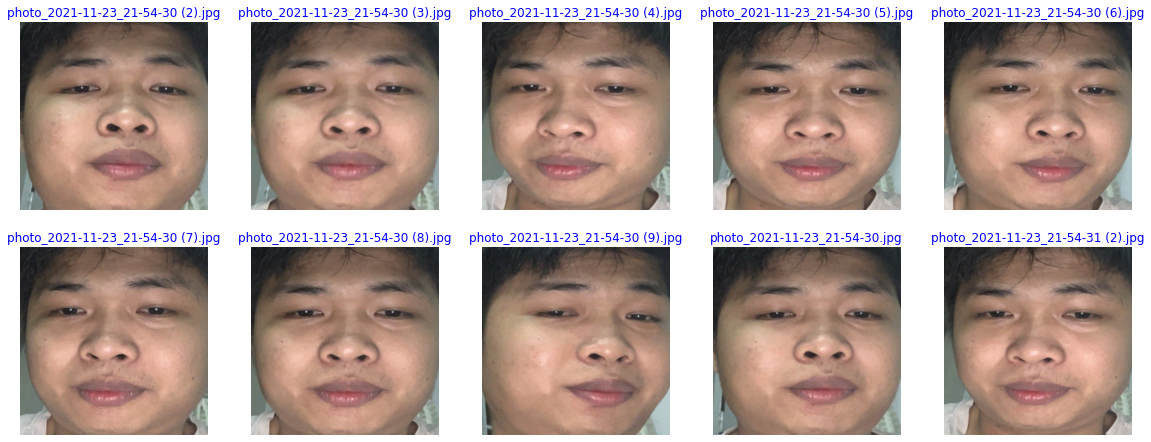

In [9]:
show_dir=os.path.join(dest_dir, 'Cropped_Images')
idx = 0
first_sub_dir= os.listdir(show_dir)[idx]
first_dir = os.path.join(show_dir, first_sub_dir)
show_images(first_dir)

show the aligned images before being cropped

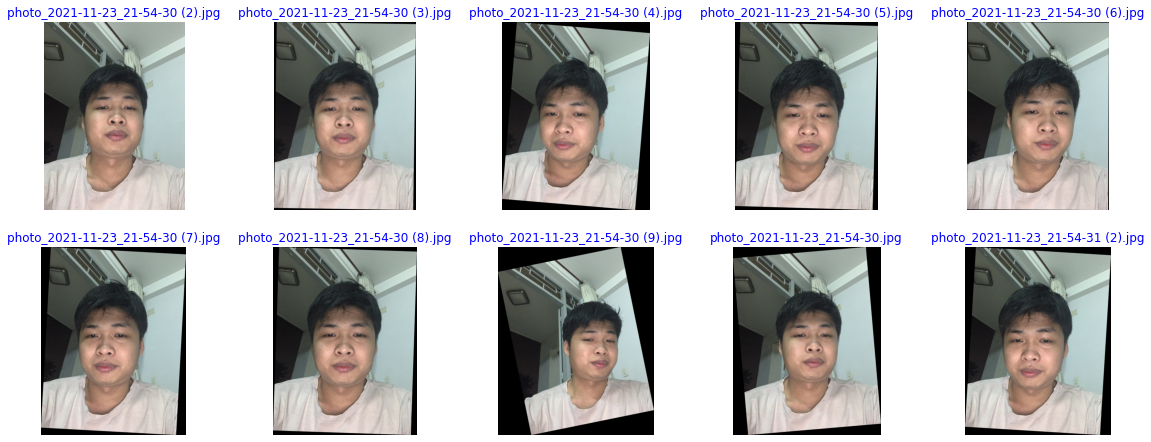

In [10]:
dir_Aligned=os.path.join(dest_dir, 'Aligned Images')
first_sub_dir= os.listdir(dir_Aligned)[idx]
first_dir = os.path.join(dir_Aligned, first_sub_dir)
show_images(first_dir)